In [1]:
import sys
import mss
import pandas as pd
import numpy as np

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

import seaborn as sns

C:\Users\scarlet_07\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

C:\Users\scarlet_07\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning:

Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [23]:
path = 'D:/UW/mssvalidation/s1.mzML'
scans = mss.mssmain.get_scans(path, ms_all=False, ms_lv=1)
#noise removal
mss.mssmain.noise_removal(scans, 5000)

In [3]:
# d_s3 = mss.mssmain.peak_list(scans, 20, enable_score=False)

In [4]:
d_md1 = pd.read_csv('D:/UW/mssvalidation/s1.txt',sep='\t')

In [5]:
d_s1 = pd.read_csv('D:/UW/mssvalidation/s1_mss.csv')

In [6]:
d_mss = d_s1[['rt', 'm/z', 'peak area']]

In [7]:
d_msdial = d_md1[['RT(min)', 'Precursor m/z', 'Area']]

In [8]:
def batch_alignment(d_ref, d_align, rt_error=0.5, mz_error=0.01):
    #Alignment of new dataset
    result = []
    for row in np.arange(len(d_ref)):
        #Find overlap using the error range
        overlap = np.where((d_align.iloc[:, 0] - rt_error <=
                                        d_ref.iloc[row, 0]) & (d_ref.iloc[row, 0] <=
                                        d_align.iloc[:, 0] + rt_error) & (d_align.iloc[:, 1] - mz_error <=
                                        d_ref.iloc[row, 1]) & (d_ref.iloc[row, 1] <=
                                        d_align.iloc[:, 1] + mz_error))
        if len(overlap[0]) == 1:
            result.append([overlap[0][0], row])
        elif len(overlap[0]) > 1:
            dist = []
            for i in overlap[0]: # if multiple hits, use the closer feature for alignment
                dist.append(np.sqrt(((d_align.iloc[i, 0] - d_ref.iloc[row, 0])**2) +
                                    ((d_align.iloc[i, 1] - d_ref.iloc[row, 1])**2)))
            result.append([overlap[0][np.argmin(dist)], row])
        
    #Modeling using overlapping features except noises
#     align_index = [i[0] for i in result]
#     ref_index = [i[1] for i in result]
#     d_align = d_align.loc[align_index]
#     d_ref = d_ref.iloc[ref_index]

#     d_align.reset_index(drop=True,inplace=True)
#     d_ref.reset_index(drop=True,inplace=True)
#     d_join = d_align.iloc[:,3:] #Important !! -- The indexing is important especially reading other feedin data
#     d_merge = pd.concat([d_ref,d_join],axis=1)
        
    return result

In [9]:
overlap = batch_alignment(d_mss, d_msdial,rt_error = 0.25,mz_error=0.01)

In [10]:
mss_index = [i[1] for i in overlap]
msd_index = [i[0] for i in overlap]

In [11]:
d_msdial.loc[msd_index]

,RT(min),Precursor m/z,Area
49,2.549067,100.0762,357172.3
43,2.200800,101.1159,2170282.0
53,3.129583,102.1282,6018235.0
436,6.595634,102.1278,550804.5
54,3.129583,103.1312,402389.3
...,...,...,...
2505,17.309000,941.9121,155769.7
1980,15.302330,1039.7330,227430.9
2892,20.111700,1277.3590,546830.5
2894,20.111700,1279.3560,447569.7


Text(0.5, 1.0, 'retention time difference distribution')

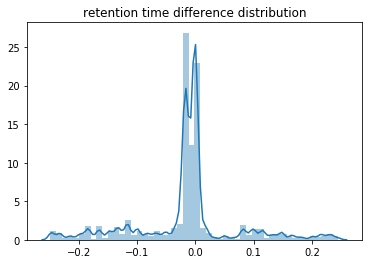

In [12]:
rtdist = list(list(d_mss.loc[mss_index]['rt']) - (d_msdial.loc[msd_index]['RT(min)']))
sns.distplot(rtdist)
plt.title('retention time difference distribution')

Text(0.5, 1.0, 'm/z difference distribution')

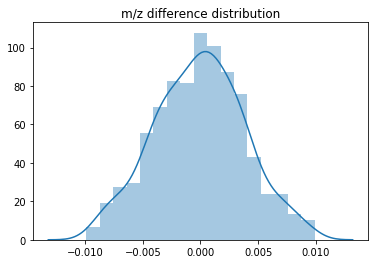

In [13]:
rtdist = list(list(d_mss.loc[mss_index]['m/z']) - (d_msdial.loc[msd_index]['Precursor m/z']))
sns.distplot(rtdist)
plt.title('m/z difference distribution')

Text(0.5, 1.0, 'Peak area difference distribution')

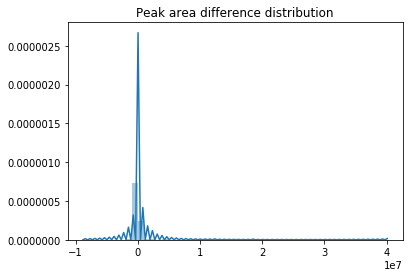

In [14]:
rtdist = list(list(d_mss.loc[mss_index]['peak area']) - (d_msdial.loc[msd_index]['Area']))
sns.distplot(rtdist)
plt.title('Peak area difference distribution')

Text(0.5, 1.0, 'rt_error = 0.25, mz_error = 0.01 Da')

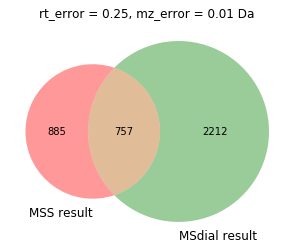

In [15]:
venn2(subsets = (885, 2212, 757), set_labels = ('MSS result', 'MSdial result'))
plt.title('rt_error = 0.25, mz_error = 0.01 Da')

In [16]:
#distribution of mass error and rt error in aligned features
#summary of peak area in unique and overlapped ones
#score assessment

Text(0.5, 1.0, 'overlap scoring')

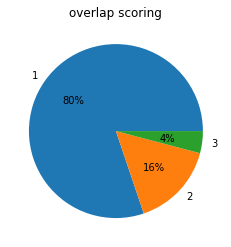

In [21]:
plt.pie(d_s1.loc[mss_index]['score'].value_counts(),labels=list(set(d_s1['score'])), autopct='%1.0f%%');
plt.title('overlap scoring')
#plt.xticks([1,2,3])

Text(0.5, 1.0, 'unique features scoring')

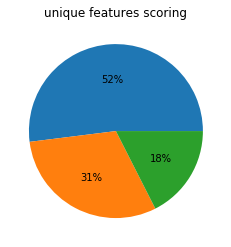

In [22]:
plt.pie(d_s1.loc[[i for i in d_s1.index if i not in mss_index]]['score'].value_counts(), autopct='%1.0f%%');
plt.title('unique features scoring')

In [44]:
d_msdial.loc[[i for i in d_msdial.index if i not in msd_index]]

,RT(min),Precursor m/z,Area
0,0.59215,105.9635,233135.70
1,0.59215,107.9599,132922.30
2,0.59215,110.0088,521536.60
3,0.59215,111.0117,82580.55
4,0.59215,112.0069,75445.54
...,...,...,...
2964,21.20623,141.9593,15008850.00
2965,21.20623,182.9832,728052.60
2966,21.27257,128.9878,644385.40
2967,21.28915,113.9649,1128074.00


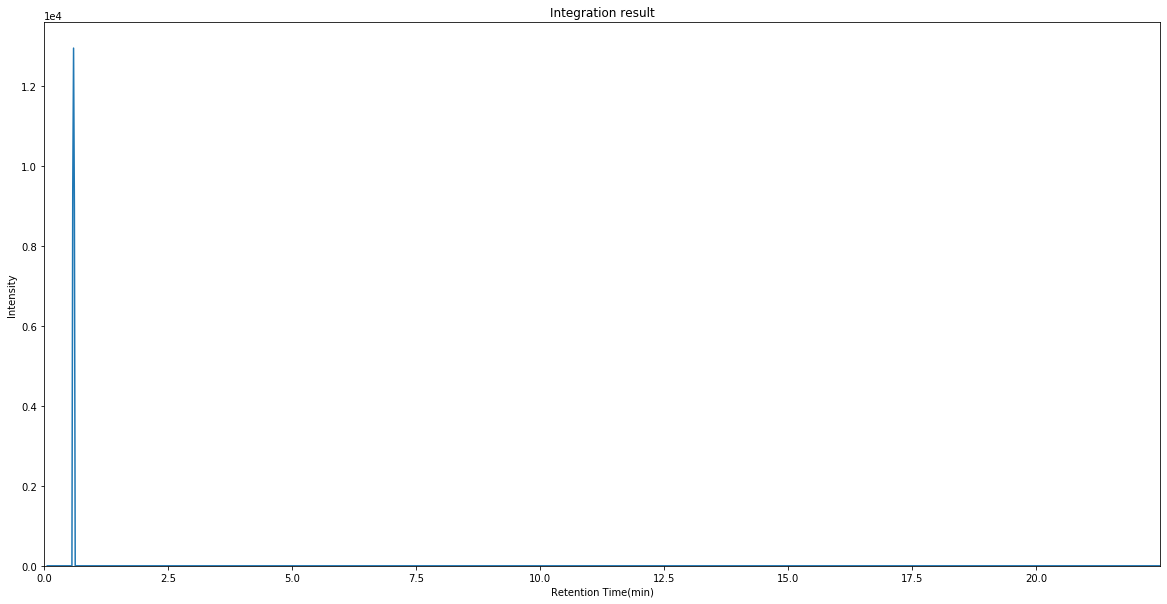

In [49]:
mss.visreader.integration_plot(scans, 111.0117, 20)